In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
images_path = "/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/Images"
train_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/train.xlsx'
test_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/test.xlsx'

In [5]:
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [6]:
print(len(train_df))
print(len(test_df))

5247
584


In [7]:
trdata = {
    'image': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)


In [8]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4663]
validdf= combinedf[4663:]

In [9]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5247
4663
584
584


In [10]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [11]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [12]:
traindf

,image,label
0,buildingfire_2017-02-05_04-06-10.jpg,1
1,isiscrimes_2015-08-04_00-18-33.jpg,5
2,earthquake_2017-11-13_07-23-10.jpg,1
3,ad_2017-11-25_07-56-53.jpg,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,4
...,...,...
4658,ad_2017-11-25_09-56-23.jpg,0
4659,hurricaneirma_2017-11-21_19-52-42.jpg,2
4660,yemencrisis_2016-02-13_02-40-54.jpg,5
4661,building_2017-10-30_17-03-48.jpg,0


In [13]:
validdf

,image,label
4663,treesfalling_2013-12-22_18-58-11.jpg,2
4664,ad_2017-11-25_04-12-10.jpg,0
4665,ad_2017-11-25_10-45-52.jpg,0
4666,naturaldisaster_2017-10-13_07-10-42.jpg,2
4667,wreckedcar_2017-02-12_16-59-16.jpg,1
...,...,...
5242,cars_2017-10-30_17-48-22.jpg,0
5243,buildingfire_2016-12-07_17-48-56.jpg,3
5244,nature_2017-10-30_17-47-15.jpg,0
5245,ad_2017-11-25_11-07-37.jpg,0


In [14]:
testdf

,image,label
0,ad_2017-11-25_10-36-26.jpg,0
1,building_2017-10-30_17-26-34.jpg,0
2,floodwater_2017-09-04_04-46-10.jpg,4
3,accrafloods_2015-06-06_16-59-56.jpg,4
4,buildingfire_2016-10-02_03-07-17.jpg,3
...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,4
580,nature_2017-10-30_17-47-50.jpg,0
581,earthquake_2017-11-13_23-23-28.jpg,1
582,ad_2017-11-25_08-21-38.jpg,0


In [15]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2367
1    1114
2     405
4     300
3     274
5     203
Name: label, dtype: int64


In [16]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     54
4     48
3     35
5     16
Name: label, dtype: int64


In [17]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [18]:
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [20]:
train_dataset = CustomDataset(traindf, images_path, transform=transform_train)
validation_dataset = CustomDataset(validdf, images_path, transform=transform_test)
test_dataset = CustomDataset(testdf, images_path, transform=transform_test)

In [21]:
class_counts = traindf['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
class_weights = class_weights / class_weights.sum()

In [22]:
class_weights = class_weights.to(device,dtype=torch.float32)

In [23]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        # Remove the last fully connected layer
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [24]:
model = CustomResNet(num_classes=6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


In [25]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader= DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [26]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

37
5
5


In [27]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# for idx, (images, labels) in enumerate(train_loader):
#     try:
#         if images.shape[1] == 1:
#             print('Image batch dimensions:', idx, images.shape)
#             print('Image label dimensions:', idx, labels.shape)
#     except Exception as e:
#         print(f"Error occurred while processing batch {idx}: {e}")

# print("No")

In [28]:
model.to(device)

CustomResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [29]:
learning_rate = 0.00001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [30]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate,
                       betas=(momentum, beta_2),
                       eps=epsilon,
                       weight_decay=weight_decay,
                       amsgrad=amsgrad)

num_iters=10000
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [31]:
iter= 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter+=1

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct_predictions / total_samples
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch [1/274], Train Loss: 1.6412, Accuracy: 0.3065
Epoch [1/274], Validation Loss: 1.5905, Accuracy: 0.3322
Epoch [2/274], Train Loss: 1.4788, Accuracy: 0.4448
Epoch [2/274], Validation Loss: 1.4521, Accuracy: 0.4709
Epoch [3/274], Train Loss: 1.3982, Accuracy: 0.4947
Epoch [3/274], Validation Loss: 1.3840, Accuracy: 0.5086
Epoch [4/274], Train Loss: 1.3565, Accuracy: 0.5068
Epoch [4/274], Validation Loss: 1.3568, Accuracy: 0.5188
Epoch [5/274], Train Loss: 1.3290, Accuracy: 0.5087
Epoch [5/274], Validation Loss: 1.3363, Accuracy: 0.5171
Epoch [6/274], Train Loss: 1.3158, Accuracy: 0.5091
Epoch [6/274], Validation Loss: 1.3198, Accuracy: 0.5188
Epoch [7/274], Train Loss: 1.2923, Accuracy: 0.5119
Epoch [7/274], Validation Loss: 1.3027, Accuracy: 0.5188
Epoch [8/274], Train Loss: 1.2779, Accuracy: 0.5130
Epoch [8/274], Validation Loss: 1.2888, Accuracy: 0.5188
Epoch [9/274], Train Loss: 1.2675, Accuracy: 0.5186
Epoch [9/274], Validation Loss: 1.2736, Accuracy: 0.5240
Epoch [10/274], Tra

In [32]:
#iters=0 
#for epoch in range(num_epochs):
#     for i, (im, la) in enumerate(train_loader):

#         im = im.to(device)
#         la = la.to(device)

#         # Clear gradients w.r.t. parameters
#         optimizer.zero_grad()

#         # Forward pass to get output/logits
#         outputs = model(images)

#         # Calculate Loss: softmax --> cross entropy loss
#         loss = criterion(outputs, la)

#         # Getting gradients w.r.t. parameters
#         loss.backward()

#         # Updating parameters
#         optimizer.step()

#         iters += 1

#         if iters % 50 == 0:
#             # Calculate Accuracy
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for images, labels in valid_loader:

#                 images = images.to(device)

#                 # Forward pass only to get logits/output
#                 outputs = model(images)

#                 # Get predictions from the maximum value
#                 _, predicted = torch.max(outputs, 1)

#                 # Total number of labels
#                 total += labels.size(0)


#                 # Total correct predictions
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()

#             accuracy = 100 * correct.item() / total

#             # Print Loss
#             print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

In [39]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [42]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

true_labels = np.array(true_labels)
predicted_labels = np.array(predictions)
target_names = ['non_damage', 'damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print("Classification Report:")
print(report)

Evaluation Metrics:
Accuracy: 0.7500
Precision: 0.7467
Recall: 0.7500
F1 Score: 0.7459
Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.83      0.88      0.86       291
damaged_infrastructure       0.72      0.72      0.72       144
        damaged_nature       0.49      0.51      0.50        55
                 fires       0.67      0.65      0.66        37
                 flood       0.74      0.47      0.58        36
          human_damage       0.56      0.43      0.49        21

              accuracy                           0.75       584
             macro avg       0.67      0.61      0.63       584
          weighted avg       0.75      0.75      0.75       584



In [34]:
print(len(train_acc_history))
print(len(train_loss_history))
print(len(test_acc_history))

274
274
274


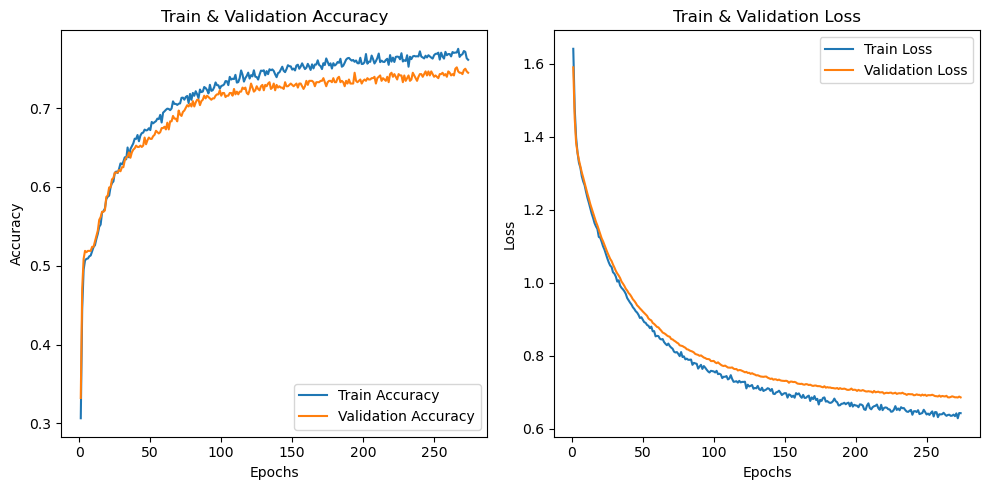

In [36]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+ 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc_history, label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()